# Arbre de décision

Par Serigne DIOP

### Choix du modéle

L'arbre de décision est un bon choix pour la classification du cancer cervical en raison de sa capacité à gérer des données complexes et à capturer des interactions entre les variables. Son interprétabilité permet aux médecins de visualiser facilement les critères influençant le diagnostic, tout en offrant de bonnes performances sur des jeux de données médicaux limités.

### Importation des librairies

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import pickle  
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split,KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict, cross_val_score

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
#from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, auc

### Importation du fichier des variables

In [2]:
with open("Variables/variables.pkl", "rb") as f:
    df, X_train, X_test, y_train, y_test, X_train_smote, y_train_smote = pickle.load(f)

print("Les données ont été chargées avec succès.")

Les données ont été chargées avec succès.


### Instantion, entrainement et évaluation


Accuracy sur le test set: 0.86
AUC sur le test set: 0.90


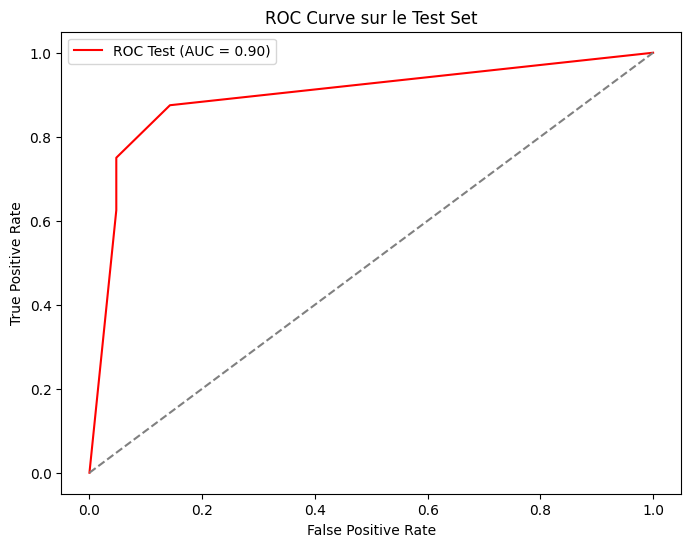

In [3]:
# Initialisation des paramètres
mean_fpr = np.linspace(0, 1, 100)  # Axe X pour la courbe ROC
tprs = []
accuracies = []

# Définir le modèle
model_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=5, 
                                    class_weight='balanced', random_state=42)

# Définir la validation croisée stratifiée à 5 plis
cv = KFold(n_splits=5, shuffle=True, random_state=18)

# Obtenir les prédictions probables avec cross-validation
y_prob = cross_val_predict(model_tree, X_train_smote, y_train_smote, cv=cv, method="predict_proba")[:, 1]

# Obtenir la précision avec cross-validation
accuracies = cross_val_score(model_tree, X_train_smote, y_train_smote, cv=cv, scoring="accuracy")
# Entraîner le modèle sur tout le train set
model_tree.fit(X_train_smote, y_train_smote)

# Prédire sur le test set
y_prob_test = model_tree.predict_proba(X_test)[:, 1]  
y_pred_test = model_tree.predict(X_test)

# Évaluer sur le test set
test_accuracy = accuracy_score(y_test, y_pred_test)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
roc_auc_test = auc(fpr_test, tpr_test)

print(f"\nAccuracy sur le test set: {test_accuracy:.2f}")
print(f"AUC sur le test set: {roc_auc_test:.2f}")

# Tracer la courbe ROC pour le test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='red', label=f'ROC Test (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve sur le Test Set')
plt.legend()
plt.show()


### Interprétation

Cette courbe ROC montre de bons résultats sur les données de test. Cependant, il est possible que notre modèle soit bien adapté à cet échantillon mais moins généralisable à de nouvelles données. Pour évaluer sa robustesse et sa capacité de généralisation, appliquons la cross-validation afin de vérifier ses performances sur plusieurs sous-échantillons

### Courbe ROC aprés Cross-Validation


Précision du modèle : 0.82


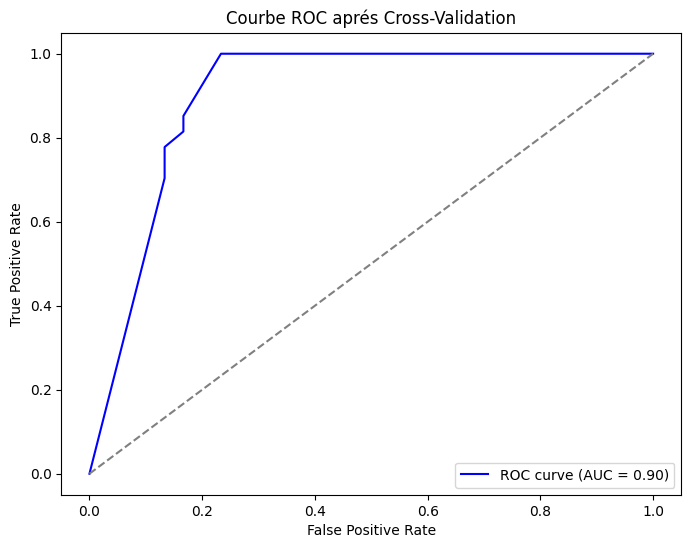

In [4]:
# Courbe ROC moyenne
fpr, tpr, _ = roc_curve(y_train_smote, y_prob)
roc_auc = auc(fpr, tpr)

# Affichage des résultats
print(f"\nPrécision du modèle : {np.mean(accuracies):.2f}")

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonale aléatoire
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC aprés Cross-Validation')
plt.legend()
plt.show()

### Analyse et interprétation

### Optimisation 

Meilleurs hyperparamètres :  {'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 20}
Meilleure précision obtenue :  0.9133333333333334

Précision moyenne du modèle après optimisation : 0.84


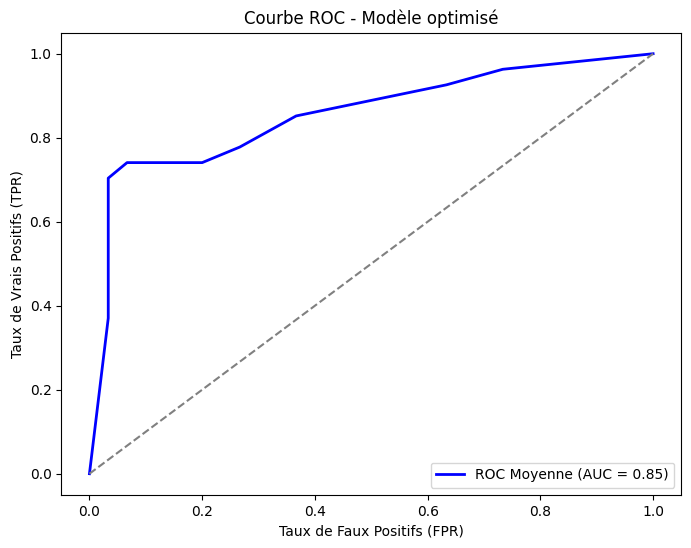

In [5]:
# Définition de la grille d'hyperparamètres pour GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

# Initialisation du modèle de l'arbre de décision
model_tree_opt = DecisionTreeClassifier(random_state=42)

# Initialisation de la validation croisée à 5 folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Création de GridSearchCV avec 5-fold cross-validation
grid_search = GridSearchCV(estimator=model_tree_opt, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy')

# Entraînement avec la validation croisée
grid_search.fit(X_train_smote, y_train_smote)

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Affichage de la meilleure précision obtenue
print("Meilleure précision obtenue : ", grid_search.best_score_)

# Initialisation des variables pour stocker les résultats des 5 folds
accuracies = []
mean_fpr = np.linspace(0, 1, 100)
tprs = []
mean_auc = 0


# Initialisation de la validation croisée
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Récupérer le meilleur modèle trouvé par GridSearchCV
best_model_opt = grid_search.best_estimator_

# Prédictions des probabilités pour chaque fold via cross-validation
y_prob = cross_val_predict(best_model_opt, X_train_smote, y_train_smote, cv=cv, method="predict_proba")[:, 1]

# Précision moyenne obtenue par validation croisée
accuracies = cross_val_score(best_model_opt, X_train_smote, y_train_smote, cv=cv, scoring="accuracy")
mean_accuracy = np.mean(accuracies)

# Courbe ROC globale
fpr, tpr, _ = roc_curve(y_train_smote, y_prob)
roc_auc = auc(fpr, tpr)

# Affichage des résultats
print(f"\nPrécision moyenne du modèle après optimisation : {mean_accuracy:.2f}")

# Tracer la courbe ROC moyenne
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Moyenne (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonale aléatoire
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC - Modèle optimisé')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix:
[[21  0]
 [ 2  6]]

 Rapport de Classification :
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        21
           1       1.00      0.75      0.86         8

    accuracy                           0.93        29
   macro avg       0.96      0.88      0.91        29
weighted avg       0.94      0.93      0.93        29



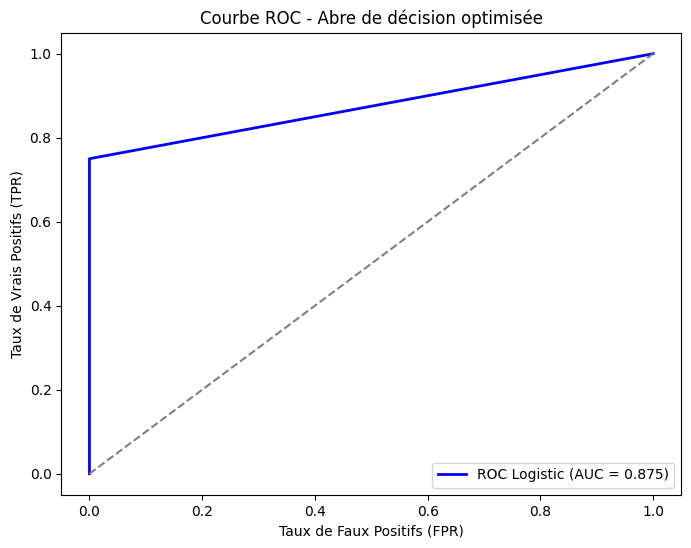

In [6]:
scaler = StandardScaler() # Normalisation des données
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test) 

# Entraînement du modèle optimisé
best_model_opt.fit(X_train_scaled, y_train_smote)

# Prédictions sous forme de probabilités
y_pred = best_model_opt.predict(X_test_scaled)

# Matrice de confusion et rapport de classification
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")
print("\n Rapport de Classification :\n", classification_report(y_test, y_pred))

# Calcul des courbes ROC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Logistic (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC - Abre de décision optimisée')
plt.legend(loc="lower right")
plt.show()

### Interpretation

L’égalité des performances après cross-validation et après optimisation peut s’expliquer par le fait que le modèle initial était déjà bien ajusté aux données. Cela signifie que les hyperparamètres choisis avant l’optimisation étaient proches des valeurs optimales, ou que le modèle a atteint son potentiel maximal sur cet ensemble de données. De plus, si les données sont homogènes, alors l’optimisation n’apporte pas de gain significatif en termes de performance. Toutefois, cela ne remet pas en cause l’intérêt de l’optimisation, qui permet généralement d’améliorer la capacité de généralisation du modèle, même si cela ne se traduit pas toujours par une augmentation des scores de performance.

### Critiques

Avec ce jeu de données de seulement 72 observations, l’utilisation d’un arbre de décision présente des risques de surajustement(overfiting), car ce modèle peut trop s’adapter aux données d’entraînement et échouer à généraliser. De plus, la cross-validation est moins fiable avec un petit échantillon, ce qui peut entraîner une variance élevée dans les résultats. L'optimisation des hyperparamètres n'a pas améliorer significativement les performances. Pour un problème aussi important que le cancer cervical, il serait préférable d'explorer des modèles plus robustes et de disposer d'un plus grand jeu de données pour améliorer la fiabilité des prédictions.

### Exporter les variables

In [7]:
roc_data_tree = {
    'fpr_dt': fpr,
    'tpr_dt': tpr,
    'roc_dt': roc_auc,
    'pred_dt': y_pred
}

# Sauvegarder les données dans un fichier pickle
with open('Variables/roc_data_tree.pkl', 'wb') as file:
    pickle.dump(roc_data_tree, file)

print("Les données ROC et AUC ont été enregistrées avec succès dans 'roc_data_tree.pkl'.")

Les données ROC et AUC ont été enregistrées avec succès dans 'roc_data_tree.pkl'.
